# Preprocessing pipeline

---

## Naming conventions

**.jams**

[Guitarist]\_[Genre][ChordProgression]-[bpm]-[key]\_[Solo or Chords]

Example:

00_BN1-129-Eb_solo.jams

**.wav**

[Guitarist]\_[Genre][ChordProgression]-[bpm]-[key]\_[Solo or Chords]\_[Pickup]\_[Processing]

Example:

00_BN1-129-Eb_solo_hex_cln.wav

## Structure

**Audio**

1. Load .wav file
1. Resample .wav file from 44kHz to 22 kHz
1. Constant-Q Transformatiom
1. Extract Frames
1. Generate windows with 9 frames width

**Labels**

1. Load corresponding .jams file
1. Extract Midi notes and timestamps
1. Generate Labels per window

## Example

### Imports

In [93]:
# import libraries
import librosa
import librosa.display
import jams
import pandas as pd
import numpy as np
import IPython
import os

import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [94]:
OUTPUT_PATH = "../data/output/"
WINDOW_SIZE = 9

### Load .wav file and .jams file

In [95]:
# example files
annot_file = "00_BN1-129-Eb_solo.jams"
audio_file = "00_BN1-129-Eb_solo_mic.wav"

# get current working directory
swizzle_dir = '/'.join(os.getcwd().split('/')[:-1])
annot_dir = swizzle_dir + '/data/raw/annotation/'
audio_dir = swizzle_dir + '/data/raw/audio_mono-mic/'

# load annotation file and audio file
annot = jams.load(annot_dir+annot_file)
audio, sr = librosa.load(audio_dir+audio_file, sr=22050)

# normalize audio
audio = librosa.util.normalize(audio)

In [96]:
IPython.display.Audio(audio_dir+audio_file)

### Extract midinotes and timestamps

**Extract data**

In [97]:
df_midi = pd.DataFrame()

# get midi notes for all strings for complete song
for idx, i in enumerate(annot['annotations']['note_midi']):
    # extract string played
    string = [idx] * len(i['data'])

    # build temporary table with midi data and string number
    temp = pd.concat([pd.DataFrame(string), pd.DataFrame(i['data'])], axis=1)

    # update df_midi
    df_midi = pd.concat([df_midi, temp], axis=0)
    del temp, string

# calculate the end_time of a note by adding time and duration
df_midi['end_time'] = df_midi['time'] + df_midi['duration']

# correct midi notes
df_midi['corrected_value'] = np.round(df_midi['value'], 0)
df_midi['corrected_value'] = df_midi['corrected_value'].astype('int')


# sort dataframe by time and reset the index
df_midi = df_midi.sort_values(by='time').reset_index()

# drop index and confidence columns
df_midi.drop(['confidence', 'index'], axis=1, inplace=True)

df_midi.head(10)

,0,time,duration,value,end_time,corrected_value
0,2,0.008544,0.174150,56.178840,0.182694,56
1,0,0.009973,0.214785,46.000264,0.224757,46
2,1,0.015052,0.168345,51.216753,0.183397,51
3,1,0.186957,0.301859,53.184436,0.488816,53
4,2,0.187705,0.290249,57.735271,0.477955,58
5,1,0.497365,0.423764,52.212377,0.921129,52
6,2,0.498816,0.348299,52.136444,0.847116,52
7,1,0.928091,0.098685,52.146564,1.026776,52
8,1,1.027410,0.406349,53.078418,1.433760,53
9,2,1.438023,0.243810,57.152928,1.681832,57


In [98]:
df_midi.shape

(71, 6)

In [99]:
# read in conversion table (midi <-> note <-> frequency)
# source: https://musicinformationretrieval.com/midi_conversion_table.html
df_conv = pd.read_csv('../data/raw/midi_annotations/conversion_table.csv', usecols=['note', 'midi-ET', 'Hertz-ET'])
df_conv.head(5)

,note,midi-ET,Hertz-ET
0,Cb0,11,15.434
1,C0,12,16.352
2,Db0,13,17.324
3,C#0,13,17.324
4,D0,14,18.354


In [100]:
# merge df_midi with conversion table
df_midi = df_midi.merge(df_conv, left_on='corrected_value', right_on='midi-ET', how='left')

# drop duplicates (Eb == D#, C# == Db, etc pp)
df_midi.drop_duplicates(subset=['time', 'duration', 'value', 'end_time'], keep='last', inplace=True)

# rename string column from 0 to 'string'
df_midi = df_midi.rename(mapper={0: 'string'}, axis=1)

df_midi.head(10)

,string,time,duration,value,end_time,corrected_value,note,midi-ET,Hertz-ET
1,2,0.008544,0.174150,56.178840,0.182694,56,G#3,56,207.65
3,0,0.009973,0.214785,46.000264,0.224757,46,A#2,46,116.54
5,1,0.015052,0.168345,51.216753,0.183397,51,D#3,51,155.56
7,1,0.186957,0.301859,53.184436,0.488816,53,E#3,53,174.61
9,2,0.187705,0.290249,57.735271,0.477955,58,A#3,58,233.08
11,1,0.497365,0.423764,52.212377,0.921129,52,E3,52,164.81
13,2,0.498816,0.348299,52.136444,0.847116,52,E3,52,164.81
15,1,0.928091,0.098685,52.146564,1.026776,52,E3,52,164.81
17,1,1.027410,0.406349,53.078418,1.433760,53,E#3,53,174.61
18,2,1.438023,0.243810,57.152928,1.681832,57,A3,57,220.00


/var/folders/80/hwh06q8n6q14ph9lgk7hmtj00000gn/T/ipykernel_11956/252434651.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(['E', 'A', 'D', 'G', 'B', 'e']);


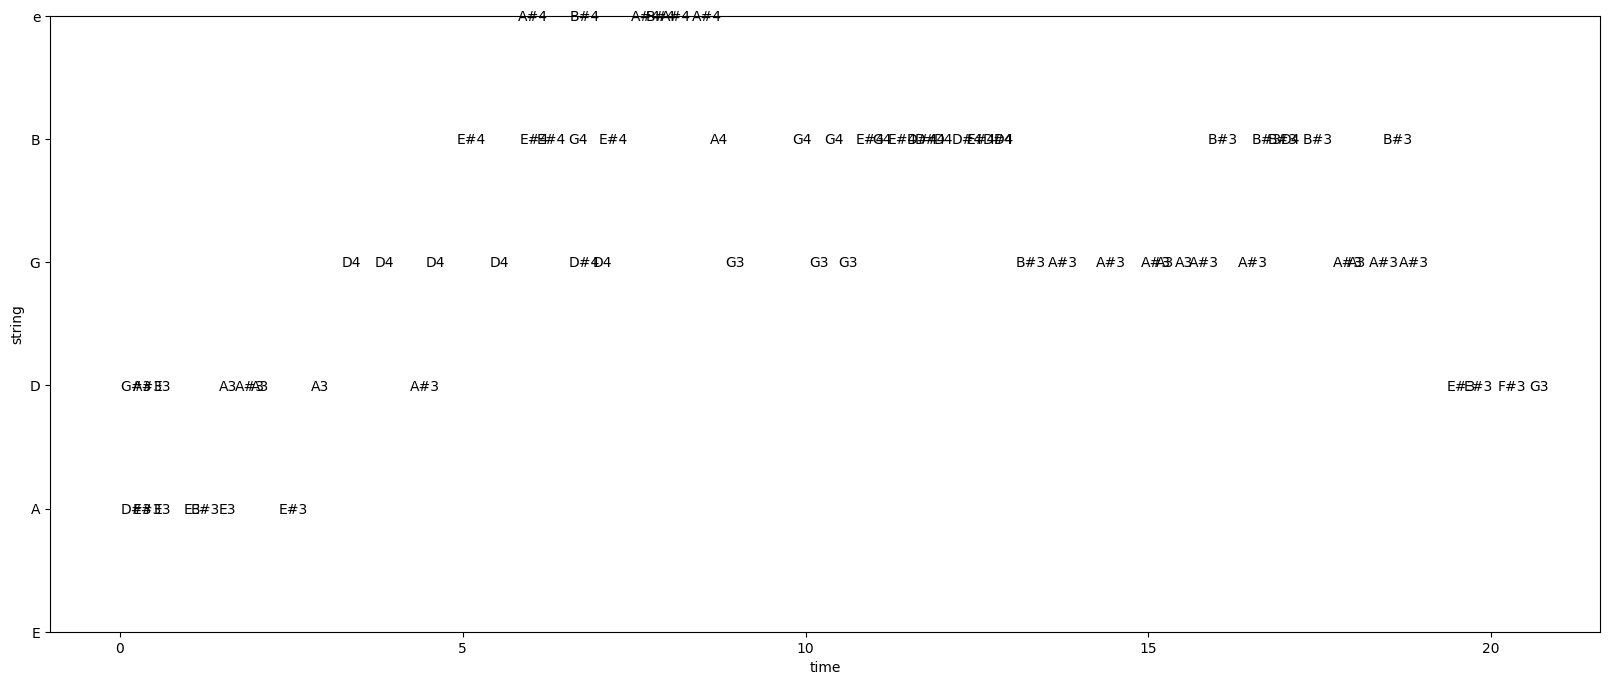

In [101]:
# plot result
fig, ax = plt.subplots(figsize=(20, 8))

# scatter plot: string vs time
fig = sns.scatterplot(data=df_midi, x='time', y='string', marker='');

# annotations: notes played
for i in df_midi.values:
    fig.annotate(i[6], xy=(i[1], i[0]-0.04))

fig.set_ylim(0, 5);
fig.set_yticklabels(['E', 'A', 'D', 'G', 'B', 'e']);

### Generate spectrogram from .wav file

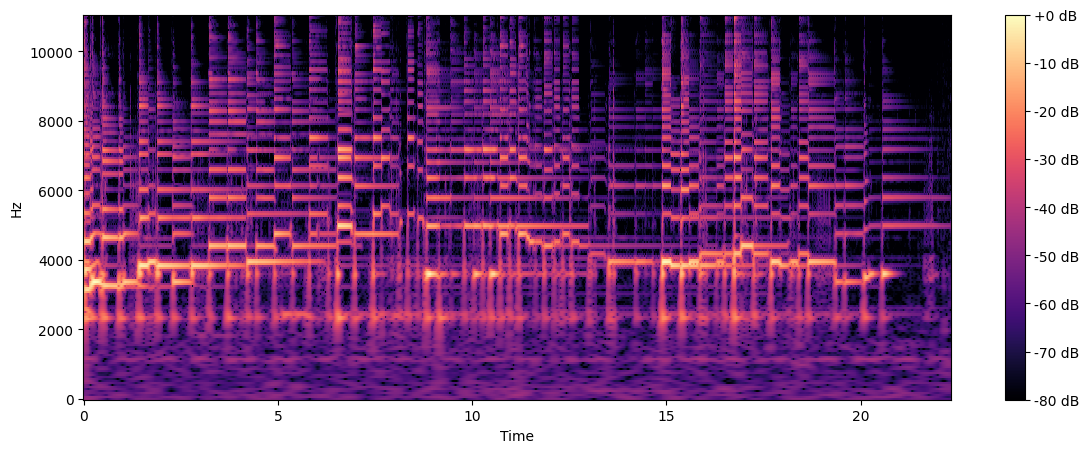

In [102]:
# ConstantQ transformation
# it's a function of amplitude vs log(freq)
# hop_length of 512 corresponds to a framerate of 43 fps
# with for example 22 seconds, this will result in ~ 950 values
deepest_note = 'E2'
hop_length = 512

audio_cqt = np.abs(librosa.cqt(audio, sr=sr, hop_length=hop_length, n_bins=192, bins_per_octave=24))

# Convert amplitude to sound pressure level in decibel (dB)
audio_cqt_dB = librosa.amplitude_to_db(audio_cqt, ref=np.max)

# Plot the resulting spectrogram (Frequency vs. Time, colorcode: dB)
# using specshow with y_axis='log', signals happening in the midrange are better visible
fig, ax = plt.subplots(figsize=(14, 5))
img = librosa.display.specshow(audio_cqt_dB, sr=sr, x_axis='time', y_axis='hz', ax=ax) # change y_axis to 'cqt_note' if you want to see the notes
fig.colorbar(img, ax=ax, format="%+2.f dB");

### Extract sliding windows from spectrogram

In [103]:
def pad_frame(input, width: int = 9, left: bool = True):
    """Padding function to account for windows which left or right bounds are
    < 0 or > len(input)

    Args:
        input (list): frame to be padded
        width (int, optional): Window width. Defaults to 9.
        left (bool, optional): Left or right padding. Defaults to True.

    Returns:
        list: the padded input.
    """
    orig_width = len(input)
    padding = width - orig_width

    input = list(input)
    
    if padding == 0:
        return np.array(input)
        
    if left:
        input = [0] * padding + input 

    else:
        input = input + [0] * padding

    return np.array(input)

In [104]:
def extract_frames(input, width: int = 9):
    """Sliding window function to extract windows with set width from an input array

    Args:
        input (list): Spectrogram
        width (int, optional): Window width. Defaults to 9 frames.

    Returns:
        list: list of windows
    """
    
    frames = []
    half_width = width//2

    # i: different frequency bins
    # j: different timepoints

    for i in input:
    
        freq_bin = []
    
        for j, _ in enumerate(i):
            
            # set left and right bounds, so that item j is centered
            lbound = j-half_width
            rbound = j+half_width+1

            # if bounds within input indices, just append 
            if lbound >= 0 and rbound <= len(input[0]):
                freq_bin.append(i[lbound:rbound])
            
            # if left bound below zero, pad left
            elif lbound < 0:
                freq_bin.append(pad_frame(i[0:rbound], width, True))

            # if right bound greater than input length, pad right
            elif rbound > len(input[0]):
                freq_bin.append(pad_frame(i[lbound:], width, False))
                
        frames.append(freq_bin)

    return frames

In [105]:
def get_windows(input):
    """wraps the output from extract_frames in one array

    Args:
        input (list): list of windows
    """
    images = []

    for j in range(len(input[0])):
        temp = []
        for i in input:
            temp.append(i[j])

        images.append(temp)
    
    return images

In [106]:
frames = extract_frames(audio_cqt)
X = get_windows(frames)

In [107]:
# get_windows does this:
# np.swapaxes(nn_input,0,1)

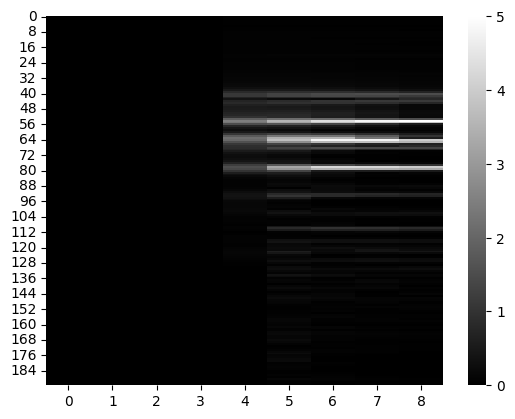

In [108]:
sns.heatmap(get_windows(frames)[0], cmap='gray');


### Extract corresponding label data from .jams

In [109]:
# extract and calculate key numbers
dur = librosa.get_duration(y=audio)
fps = sr // hop_length
n_frames = fps * dur
n_frames_int = int(np.round(n_frames, 0))

# ToDo: label variables with f string
print(f"Duration: {dur:.2f}s\nFrames  : {n_frames_int}\nFPS     : {fps}/s")

Duration: 22.32s
Frames  : 960
FPS     : 43/s


In [110]:
n_windows = len(get_windows(frames))
window_labels = []
times = []

for i in range(n_windows):
    lbound = ((i-(9//2))/n_windows) * dur
    rbound = ((i+(9//2))/n_windows) * dur
    window_labels.append(df_midi[(df_midi['time'] >= lbound) & (df_midi['time'] <= rbound)][['string', 'corrected_value']].values)

In [111]:
# unique notes played for this song
df_midi['corrected_value'].nunique()

17

In [112]:
def midi_to_fret(window_labels):
    tuning = [40, 45, 50, 55, 59, 64]
    fretboard = np.zeros((len(window_labels), 6, 21))
    
    # 1: get string played
    # 2: for each note played during window,
    #    get empty string midi value (esmv)
    # 3: subtract esmv from played note midi value
    # 3.1: if fret played is 0,
    # 4: replace respective value in fretboard
    # 5: set first value to 1, if all other values are 0

    for widx, window in enumerate(window_labels):
        if window.size > 0:
            for item in window:
                # empty string midi value from string played (0-5)
                esmv = tuning[item[0]]
                # convert played note to fret
                fret = item[1] - esmv + 1
                # set fret to 1 in fretboard
                fretboard[widx][item[0]][fret] = 1
    
        # if no note was played in window, set first values to 1
        elif window.size == 0: 
            for idx in range(len(fretboard[widx])):
                fretboard[widx][idx][0] = 1 

    for widx in range(len(fretboard)):
        for idx, string in enumerate(fretboard[widx]):
            if sum(string) == 0:
                fretboard[widx][idx][0] = 1
        
    # return fretboard
    return fretboard

In [113]:
y = midi_to_fret(window_labels)

### Format and shape of CNN training data

In [114]:
y.shape

(962, 6, 21)

In [116]:
np.save('../data/output/PREPRO_NOTEBOOK.npy', y)
np.savez('../data/output/PREPRO_NOTEBOOK.npz', y)

In [118]:
npy = np.load('../data/output/PREPRO_NOTEBOOK.npy')
npz = np.load('../data/output/PREPRO_NOTEBOOK.npz')['arr_0']

In [119]:
np.all(npy == npz)

True

In [ ]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [ ]:
noise_frames_idx = []
data_frames_idx = []

# loop through all frames
for fidx, frame in enumerate(y):
    
    null_strings = 0

    # loop over all strings in frame
    for sidx, string in enumerate(frame):

        # read out indices of '1's
        zero_idx = np.where(string==1)

        # if '1' is at position 0, increase null_string counter
        if np.squeeze(zero_idx).size == 1 and np.squeeze(zero_idx) == 0:
            null_strings += 1

    # check if all strings were not played
    if null_strings == 6:
        noise_frames_idx.append(fidx)
    else:
        data_frames_idx.append(fidx)

print(f"In file \"{annot_file[:-5]}\", {len(noise_frames_idx)}/{len(y)} are empty frames ({np.round(len(noise_frames_idx)/len(y), 2) * 100} %).")

In file "00_BN1-129-Eb_solo", 471/962 are empty frames (49.0 %).


In [ ]:
fraction = 0.95

mask = np.ones(len(y), dtype=bool)
noise_frames_idx = noise_frames_idx[:int(len(noise_frames_idx)*fraction)]
mask[noise_frames_idx] = False
y[mask].shape

(515, 6, 21)

In [ ]:
X = np.array(X)
X.shape

(962, 192, 9)

### Saving output of preprocessing

In [ ]:
def save_output(data: np.array, labels: np.array):
    # filename has no extenstion
    filename = audio_file.split('.')[0]
    #num_frames = self.load_rep_and_labels_from_raw_file(filename)
    #print "done: " + filename + ", " + str(num_frames) + " frames" 
    save_path = OUTPUT_PATH
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    np.savez(save_path + filename + "_data_notebook.npz", data)
    np.savez(save_path + filename + "_labels_notebook.npz", labels)

In [ ]:
save_output(X, y)

### Loading output of preprocessing

In [ ]:
X_loaded = np.load(OUTPUT_PATH+audio_file.split('.')[0]+'_data_notebook.npz')
y_loaded = np.load(OUTPUT_PATH+audio_file.split('.')[0]+'_labels_notebook.npz')

In [ ]:
X_loaded['arr_0'][0]

array([[0.        , 0.        , 0.        , ..., 0.0513216 , 0.05176711,
        0.05180302],
       [0.        , 0.        , 0.        , ..., 0.04519475, 0.04594322,
        0.04638959],
       [0.        , 0.        , 0.        , ..., 0.02387314, 0.02194534,
        0.0196947 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05259363, 0.02188895,
        0.01554752],
       [0.        , 0.        , 0.        , ..., 0.00940329, 0.00889658,
        0.00083927],
       [0.        , 0.        , 0.        , ..., 0.01782771, 0.02606779,
        0.01265987]])

<AxesSubplot:>

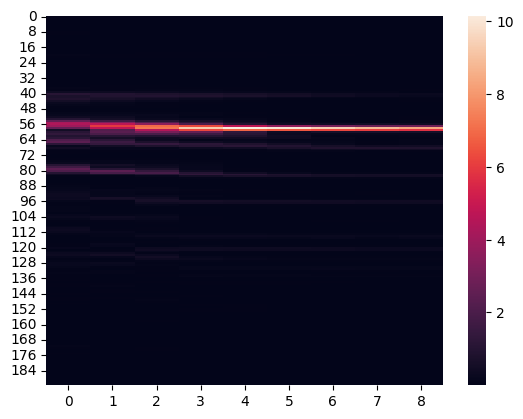

In [ ]:
sns.heatmap(X_loaded['arr_0'][12])

In [ ]:
lbound = (12-4) * (1/43)
rbound = (12+4) * (1/43)

print(lbound, rbound)

df_midi[(df_midi['time'] < rbound) & (df_midi['time'] >= lbound)]

0.18604651162790697 0.37209302325581395


,string,time,duration,value,end_time,corrected_value,note,midi-ET,Hertz-ET
7,1,0.186957,0.301859,53.184436,0.488816,53,E#3,53,174.61
9,2,0.187705,0.290249,57.735271,0.477955,58,A#3,58,233.08


In [ ]:
y_loaded['arr_0'][12]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [ ]:
window_labels[12]

array([[ 1, 53],
       [ 2, 58]])

### Preprocessing user audio data

User data will be handled a bit differently. While it is good for the CNN to see notes in different contexts for the training (hence the overlapping sliding window), it is more important to have maximum resolution while predicting on user audio.

This is why here, we implement a different approach: after the CQT, each frame is made into a 192x9 "window". The CNN then predicts on this "window" and outputs its predictions, which are now on frame level (i.e. with a resolution of frames per second).

In [ ]:
def pp_user_audio(audio, window_size):

    # perform CQT
    cqt = np.abs(librosa.cqt(audio, sr=sr, hop_length=hop_length, n_bins=192, bins_per_octave=24))

    # swap axes so it's TIME x FREQUENCIES instead of the other way around
    cqt_swapped = np.swapaxes(cqt, 0, 1)
    
    # initialize numpy array
    n_freqs, n_frames = cqt.shape
    r = np.zeros((n_frames, n_freqs, window_size))

    # construct arrays for each frame over all frequency bins
    for idx, frame in enumerate(cqt_swapped):
        r[idx] = np.swapaxes([frame] * 9, 0, 1)
    
    return r

In [ ]:
frame_windows = pp_user_audio(audio, WINDOW_SIZE)

## Tests

In [ ]:
# test padding function
test = [1, 1, 1, 1, 1, 1]
assert sum(pad_frame(test, 9, True)) == sum([0, 0, 0, 1, 1, 1, 1, 1, 1])

# test frame_windows output
# the first item of the first frame_windows array
# should match the first item in the fourth frames item
assert frames[0][4][0] == frame_windows[0][0][0]

In [ ]:
# test against test output from pipeline
np.round(frame_windows[0][0][0], 4) == np.round(4.93400028*10**-2, 4)

True

In [ ]:
a = np.array([[1, 1, 2]])
b = np.array([[1, 1, 3]])
print((a == b).any())
print(np.any(a==b))

True
True


# CHECK PREPRO.PY

In [120]:
notes_played = []

# get midi notes played per string
for string, data in enumerate(annot.annotations['note_midi']):
    for observation in range(len(data['data'])):
        notes_played.append([string, np.round(data['data'][observation][2]), data['data'][observation][0]])

# sort ascending by time
notes_played = np.array(sorted(notes_played, key=lambda x: x[-1]))

In [123]:
np.set_printoptions(precision=5, suppress=True)

notes_played

array([[ 2.     , 56.     ,  0.00854],
       [ 0.     , 46.     ,  0.00997],
       [ 1.     , 51.     ,  0.01505],
       [ 1.     , 53.     ,  0.18696],
       [ 2.     , 58.     ,  0.18771],
       [ 1.     , 52.     ,  0.49737],
       [ 2.     , 52.     ,  0.49882],
       [ 1.     , 52.     ,  0.92809],
       [ 1.     , 53.     ,  1.02741],
       [ 2.     , 57.     ,  1.43802],
       [ 1.     , 52.     ,  1.43868],
       [ 2.     , 58.     ,  1.68247],
       [ 2.     , 57.     ,  1.90678],
       [ 1.     , 53.     ,  2.31351],
       [ 2.     , 57.     ,  2.79   ],
       [ 3.     , 62.     ,  3.23963],
       [ 3.     , 62.     ,  3.71637],
       [ 2.     , 58.     ,  4.2263 ],
       [ 3.     , 62.     ,  4.46079],
       [ 4.     , 65.     ,  4.91646],
       [ 3.     , 62.     ,  5.38859],
       [ 5.     , 70.     ,  5.80771],
       [ 4.     , 65.     ,  5.82294],
       [ 4.     , 65.     ,  6.07222],
       [ 4.     , 67.     ,  6.54074],
       [ 3.     , 63.    

In [128]:
# get number of windows
n_windows = len(X)
print(n_windows)

# calculate half-width of window
half_width = 9//2 # --> 4

# Data has columns: STRING MIDI STARTTIME
# Check if note was played or is still ringing within a window's start and endtime.
# Collect all notes for which this is true and save as windowlabels.
# Repeat this for all windows

windows = []

# song_duration / n_windows --> (1/n_windows) * song_duration
# (5/n_windows - 4/n_windows) * song_duration

# lbound: (0-4)/n_windows --> -4/962 = -0.004
# rbound: (0+4)/n_windows -->  4/962 = +0.004
# --> multiply by duration translates fraction of song into seconds

for w in range(n_windows):
    lbound = ((w-half_width) / n_windows * dur)
    rbound = ((w+half_width) / n_windows * dur)

    print(f"Current timeframe: {np.round(lbound, 3):.3f} - {np.round(rbound, 3):.3f} / {np.round(dur, 3):.3f}")
    mask = ((annot[:, 2] >= lbound) & (annot[:, 2] <= rbound))
    windows.append(annot[mask, :-1])
    print(f"Found labels: {annot[mask, :-1]}")

# self._get_windowfrets(windows, n_windows)

962
Current timeframe: -0.093 - 0.093 / 22.324


TypeError: unhashable type: 'slice'